In [255]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt

import decoder

In [280]:
# logfile = "logs/networks/regular/nodes-8-degree-2-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items-gain.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-256-degree-128-seed-1-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-16-degree-8-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
logfile = "logs/networks/regular/nodes-512-degree-32-seed-7-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"

rounds = []
with open(logfile) as f:
    for line in f:
        rounds.append(json.loads(line, cls=decoder.TorchTensorDecoder))
# rounds = rounds[:128]
print(len(rounds))

71


Text(0, 0.5, 'STD[params] in each node')

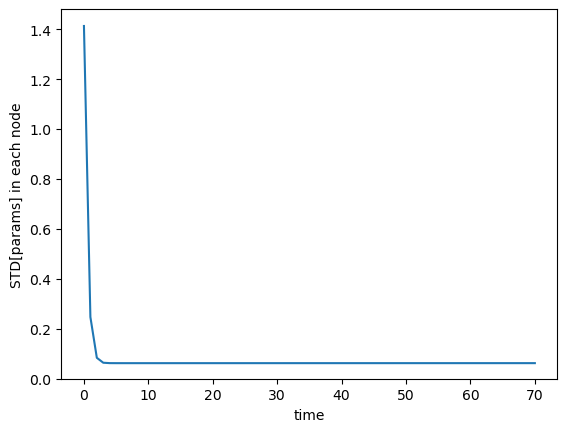

In [281]:
x = [r["round"] for r in rounds]
y = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
plt.plot(x, np.array(y))
plt.ylim(0, None)
#plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

In [282]:
np.min(y), y[-1]

(0.06233493238687515, 0.062414031475782394)

Text(0, 0.5, 'STD[param] across node')

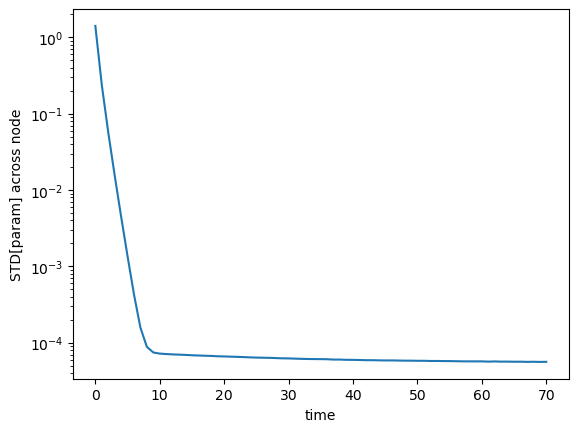

In [283]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x, y)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

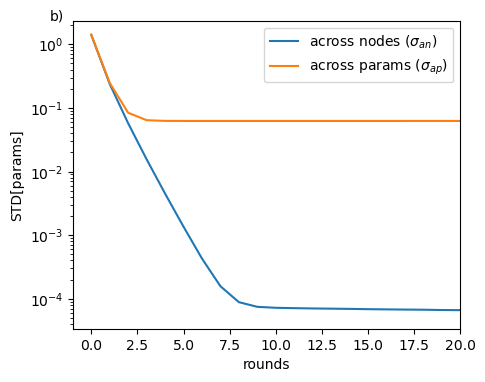

In [284]:
fig, ax = plt.subplots(figsize=(5, 4))
x = [r["round"] for r in rounds]
y_ap = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
y_an = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]

ax.plot(x, np.array(y_an), label="across nodes ($\\sigma_{an}$)")
ax.plot(x, np.array(y_ap), label="across params ($\\sigma_{ap}$)")
ax.set_xlim(-1, 20)
# ax.set_ylim(2e-5, 7e-1)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("STD[params]")
ax.text(-0.06, 1.0, "b)", transform=ax.transAxes)
fig.savefig("figures/params_stds.pdf")

Text(0, 0.5, '$|\\delta(param)|$')

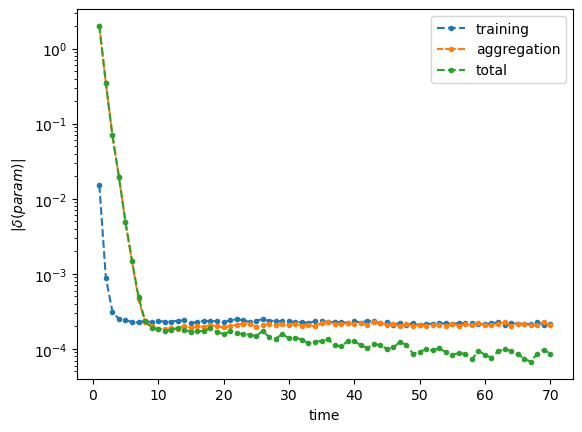

In [285]:
x = [r["round"] for r in rounds[1:]]
y1 = [r["training_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y2 = [r["aggregation_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y3 = [(r["aggregation_changes"]['0']["fc4.weight"] + r["training_changes"]['0']["fc4.weight"]).abs().mean()
      for r in rounds[1:]]
plt.plot(x, y1, label="training", marker=".", ls='--')
plt.plot(x, y2, label="aggregation", marker=".", ls=(2, (5, 1)))
plt.plot(x, y3, label="total", marker=".", ls='--')
plt.yscale("log")
plt.legend()
plt.xlabel("time")
plt.ylabel("$|\delta(param)|$")

0.46768549310439267

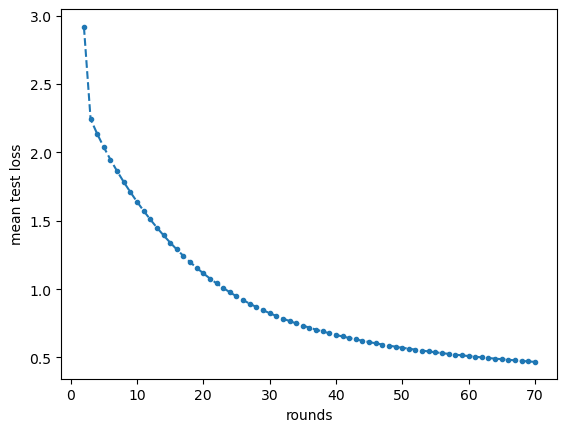

In [303]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_losses"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[2:], y[2:], yerr=yerr[2:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test loss")
y[-1]

Text(0, 0.5, 'mean test accuracy')

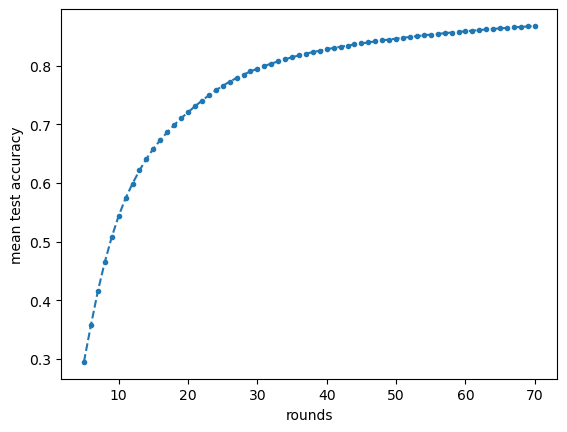

In [304]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_accuracies"])
y = np.array([np.mean([r["test_accuracies"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_accuracies"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[5:], y[5:], yerr=yerr[5:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test accuracy")

In [288]:
y[-1]

0.867766796875

Text(0, 0.5, '-diff[mean test loss]')

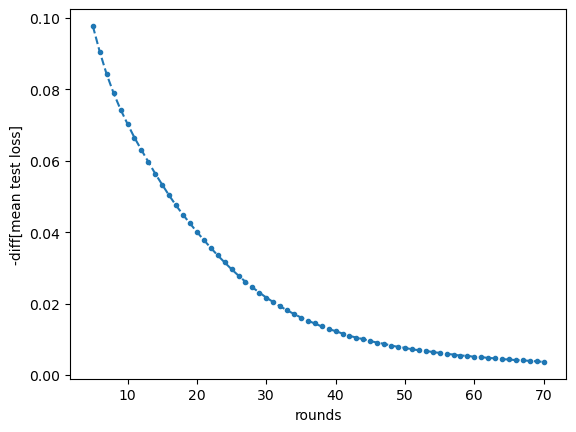

In [289]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
plt.plot(x[5:], -np.diff(y)[4:], marker=".", ls='--')
#plt.yscale("log")
#plt.ylim(1e-30, 1e-5)
plt.xlabel("rounds")
plt.ylabel("-diff[mean test loss]")

In [290]:
y[-2] - y[-1]

0.00364424257185314

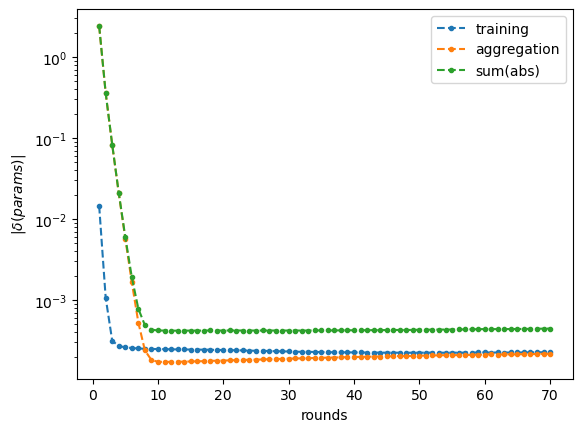

In [298]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

min_t = 1
x = [r["round"] for r in rounds[min_t:]]
nodes = list(rounds[0]["test_losses"])

param = "fc4.weight"
y_train = []
y_agg = []
y_total = []
y_sum_abs = []
y_train_agg_sim = []
for n in nodes:
    y_train.append([r["training_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_sum_abs.append([(r["aggregation_changes"][n][param].abs() + r["training_changes"][n][param].abs()).mean()
          for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param]).abs().mean()
          for r in rounds[min_t:]])
    y_train_agg_sim.append([cosine_sim(r["training_changes"][n][param], r["aggregation_changes"][n][param])
                            for r in rounds[min_t:]])
plt.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
plt.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
# plt.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
plt.plot(x, np.mean(y_sum_abs, axis=0), label="sum(abs)", marker=".", ls='--')
# plt.plot(x, np.mean(y_total, axis=0)/np.mean(y_sum_abs, axis=0), label="total/sum(abs)", marker=".", ls='--')
plt.yscale("log")
plt.ylabel("$|\\delta(params)|$")
plt.xlabel("rounds")
plt.legend()

# plt.twinx().errorbar(
#     x, np.mean(y_train_agg_sim, axis=0), yerr=np.std(y_train_agg_sim, axis=0), marker=".", ls='--', color="tab:olive")
# plt.ylabel("$S_c(\\delta_{training}, \\delta_{aggregation})$")

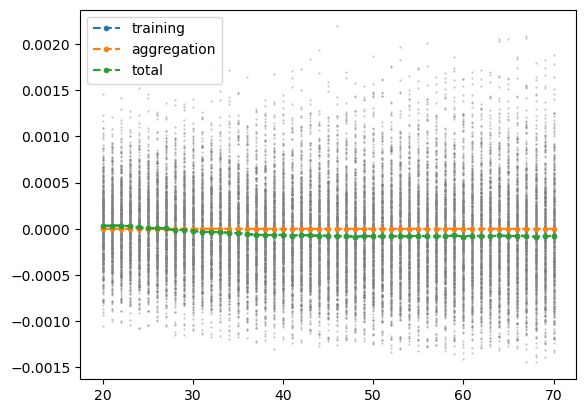

In [292]:
min_t = 20
x = [r["round"] for r in rounds[min_t:]]
idx = 10
y_train = []
y_agg = []
y_total = []
for n in nodes:
    y_train.append([r["training_changes"][n][param][idx] for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param][idx] for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param])[idx]
          for r in rounds[min_t:]])
plt.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
plt.plot(np.repeat(np.array(x)[np.newaxis, :], len(nodes), axis=0), y_train, marker=".", ms=1, ls='', color="grey", alpha=0.5)

plt.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
plt.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
plt.legend()

Text(0, 0.5, 'STD[params] in each node')

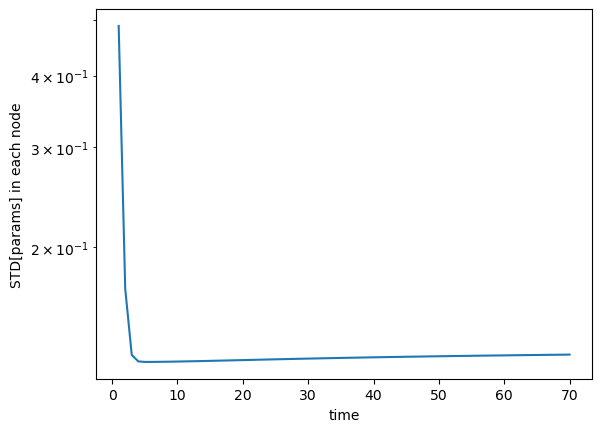

In [299]:
x = [r["round"] for r in rounds]
y = [np.mean([r["stds_across_params"][n][param] for n in nodes]) for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

Text(0, 0.5, 'STD[param] across node')

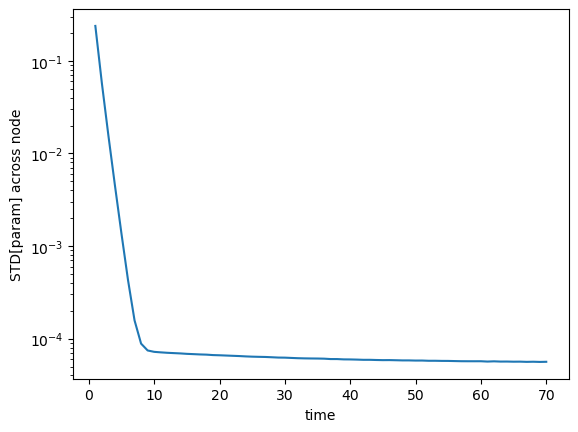

In [300]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

# Update/Data ratio

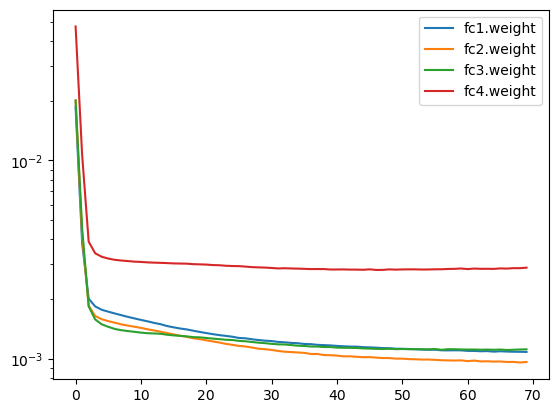

In [301]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    du = []
    for r in rounds[1:]:
        du.append([
            (r["training_changes"][n][param].std()/r["params"][n][param].std()).tolist()
            for n in nodes])
    ax.plot(np.mean(du, axis=1), label=param)
ax.legend()
ax.set_yscale("log")

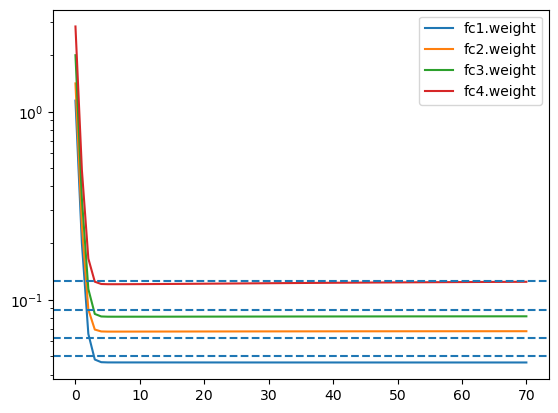

In [302]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
fan_ins = {"fc1.weight": 784, "fc2.weight": 512, "fc3.weight": 256, "fc4.weight": 128}
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    stds = []
    for r in rounds:
        weights = []
        for n in nodes:
            weights.extend(r["params"][n][param].tolist())
        stds.append(np.std(weights))
    ax.plot(stds, label=param)
    ax.axhline((2/fan_ins[param])**0.5, ls='--')
    
ax.set_yscale("log")
ax.legend()

# Scaling with size

In [ ]:
import pathlib
from tqdm import tqdm

test_losses = {}

for size in [512, 256, 128, 64]:
    files = pathlib.Path("logs/networks/regular/").glob(f"nodes-{size}-degree-32-seed-*-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl")
    for logfile in tqdm(list(files)):
        with open(logfile) as f:
            test_loss = []
            for line in f:
                j = json.loads(line, cls=decoder.TorchTensorDecoder)
                test_loss.append(np.mean(list(j["test_losses"].values())))
            if size not in test_losses:
                test_losses[size] = []
            test_losses[size].append(test_loss)
# rounds = rounds[:128]

 25%|██▌       | 3/12 [00:38<01:54, 12.76s/it]

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 11 11 11  9  7  7  7  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  5  3  3  1]
[12 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11  6]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10  9  8  5  1]
[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  9]


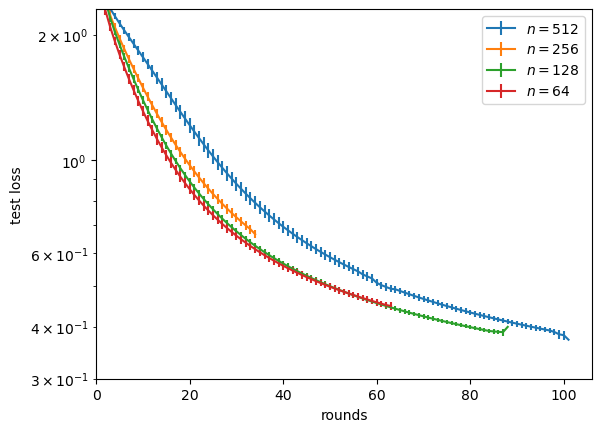

In [453]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    print(np.sum(~np.isnan(loss), axis=0))
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            label=f"$n={size}$")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.set_xlim(0, None)
ax.set_ylim(3e-1, np.log(10))
ax.legend()

/tmp/ipykernel_9679/236268835.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


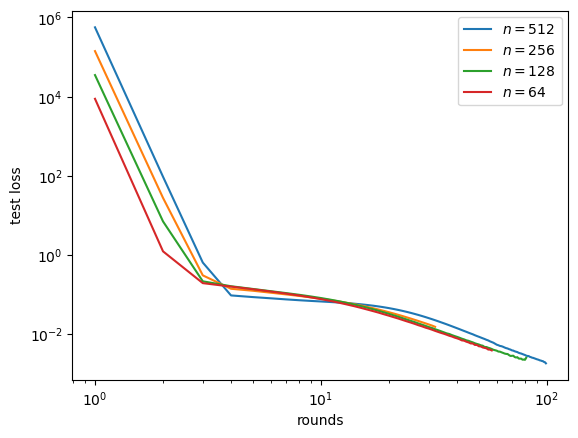

In [449]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.plot(np.arange(1, max_len),
            np.nanmean(-np.diff(loss), axis=0),
            # yerr=1.96*(np.nanstd(loss, axis=0)/(np.sum(np.array(loss) != np.nan, axis=0) - 1)**0.5),
            label=f"$n={size}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.set_xlim(0, None)
# ax.set_ylim(3e-1, np.log(10))
ax.legend()